# 2. Data Analysis and Visualization

This notebook provides comprehensive analysis and visualization of the aircraft engine fault detection dataset.

## 2.1 Dataset Structure, Fault Labels, and Sensors

### Dataset Overview

The dataset consists of simulated operational data from a fleet of **249 aircraft engines**.
For each engine, measurements are provided over **1000 consecutive cycles**. A cycle corresponds to an aggregation of measurements over 10 flight missions, resulting in a cycle-level temporal resolution.

At each cycle, **20 sensor signals** are recorded simultaneously. All sensors are synchronized across cycles and engines, and the dataset is **fully observed**, with no missing values.

In addition to sensor measurements, **fault labels** are provided at the cycle level. These labels indicate the presence of one or more fault types affecting the engine during a given cycle.

In [34]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from scipy import stats

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

In [35]:
# Configuration
PATH = '../data/Project_ENSAI_2025'
FILE_PATTERN = os.path.join(PATH, "Cie_*_Engine*.csv")
OUTPUT_DIR = '../results/data_analysis'

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Define column names
FAULT_COLS = ['corrosion', 'erosion', 'fouling', 'tip_clearance']

FEATURE_COLS = [
    'CRUISE_DTAMB', 'CRUISE_ALT', 'CRUISE_MACH', 'CRUISE_COMMAND',
    'TAKEOFF_DTAMB', 'TAKEOFF_ALT', 'TAKEOFF_MACH', 'TAKEOFF_COMMAND',
    'CRUISE_DECKSMRHPC_Tout', 'CRUISE_DECKSMRHP_Nmech', 'CRUISE_DECKSMRHPC_Tin',
    'CRUISE_DECKSMRLPT_Tin', 'CRUISE_DECKSMRFuel_flow', 'CRUISE_DECKSMRHPC_Pout_st',
    'TAKEOFF_DECKSMRHPC_Tout', 'TAKEOFF_DECKSMRHP_Nmech', 'TAKEOFF_DECKSMRHPC_Tin',
    'TAKEOFF_DECKSMRLPT_Tin', 'TAKEOFF_DECKSMRFuel_flow', 'TAKEOFF_DECKSMRHPC_Pout_st',
]

# Fault colors for visualization
FAULT_COLORS = {
    'corrosion': '#e74c3c',
    'erosion': '#3498db',
    'fouling': '#f39c12',
    'tip_clearance': '#9b59b6'
}

### Table 1 – Fault Label Definitions

This table defines the semantic meaning of the fault labels used throughout the analysis.

| Fault ID | Fault Name | Physical Interpretation | Affected Engine Module(s) | Label Type | Temporal Behavior |
|----------|------------|------------------------|---------------------------|------------|-------------------|
| 0 | Corrosion | Chemical degradation of metallic components due to oxidation or environmental exposure | HPC (High Pressure Compressor), Turbine blades | Binary | Persistent once active, progressive degradation |
| 1 | Erosion | Mechanical wear and material loss caused by particle impact or high-velocity flow | Compressor blades, Turbine nozzles | Binary | Persistent once active, progressive accumulation |
| 2 | Fouling | Accumulation of contaminants (dirt, debris, combustion residues) on surfaces | Compressor stages, Turbine cooling passages | Binary | Persistent once active, can be intermittent |
| 3 | Tip Clearance | Increased gap between rotating blade tips and stationary casing | HPC, HPT (High Pressure Turbine), LPT (Low Pressure Turbine) | Binary | Persistent once active, can vary with thermal cycles |

### Table 2 – Sensor Description

This table provides a physical interpretation of the 10 sensor types. Each sensor is measured during both CRUISE and TAKEOFF flight phases, resulting in 20 total sensor signals.

| Sensor ID | Physical Quantity Measured | Engine Module | Units | Description |
|-----------|----------------------------|---------------|-------|-------------|
| 0 | DTAMB | Ambient | K | Ambient temperature deviation |
| 1 | ALT | Flight conditions | m | Altitude |
| 2 | MACH | Flight conditions | - | Mach number |
| 3 | COMMAND | Control | % | Throttle command |
| 4 | HPC_Tout | HPC | K | High pressure compressor outlet temperature |
| 5 | HP_Nmech | HP Shaft | RPM | High pressure shaft mechanical speed |
| 6 | HPC_Tin | HPC | K | High pressure compressor inlet temperature |
| 7 | LPT_Tin | LPT | K | Low pressure turbine inlet temperature |
| 8 | Fuel_flow | Fuel system | kg/s | Fuel flow rate |
| 9 | HPC_Pout_st | HPC | Pa | High pressure compressor static outlet pressure |

In [36]:
# Load all engine data
print(f"Reading files from: {FILE_PATTERN}")

all_files = sorted(glob.glob(FILE_PATTERN))
print(f"Total engines found: {len(all_files)}")

print("Loading all engine data...")
df_list = []
for file in all_files:
    df = pd.read_csv(file, dtype={col: np.float32 for col in FAULT_COLS + FEATURE_COLS})
    df_list.append(df)

df_fleet = pd.concat(df_list, ignore_index=True)
print(f"Fleet data loaded: {len(df_fleet):,} cycles from {len(all_files)} engines")

Reading files from: ../data/Project_ENSAI_2025/Cie_*_Engine*.csv
Total engines found: 249
Loading all engine data...
Fleet data loaded: 249,000 cycles from 249 engines


## 2.2 Temporal Characteristics of Fault Labels

This subsection analyzes the fault labels independently of the sensor data in order to understand their temporal structure.

### 2.2.1 Fault Occurrence Over Cycles

**Plot 1 – Fault occurrence timeline**

This plot visualizes when faults typically occur across the engine lifetime and assesses whether faults cluster in early, middle, or late cycles.

In [37]:
# Create composite engine key from cie_id and system_id
df_fleet['engine_key'] = df_fleet['cie_id'].astype(str) + '_' + df_fleet['system_id'].astype(str)

print(f"Number of engines: {df_fleet['engine_key'].nunique()}")
print(f"Number of companies: {df_fleet['cie_id'].nunique()}")
print(f"Cycles per engine: {df_fleet.groupby('engine_key')['cycle'].count().unique()}")

Number of engines: 249
Number of companies: 6
Cycles per engine: [1000]


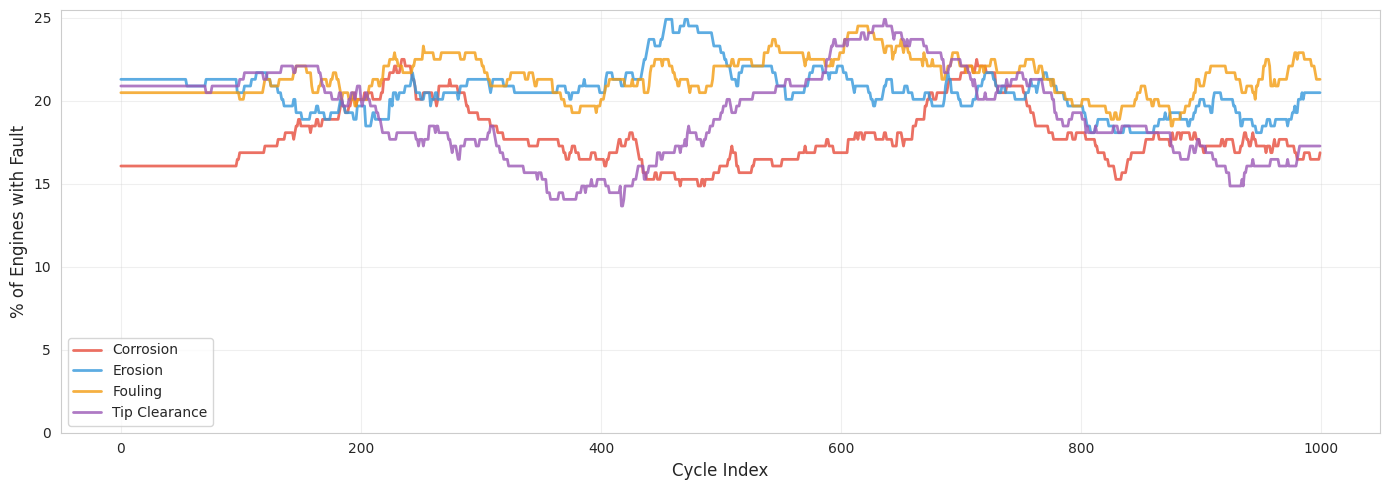

Figure 1a: Fault prevalence over engine lifecycle. The plot shows the percentage of the fleet
experiencing each fault type at each cycle, revealing temporal patterns of fault occurrence.


In [38]:
# Plot 1a: Fault prevalence timeline
fig, ax = plt.subplots(figsize=(14, 5))

# Calculate fault occurrence counts per cycle
fault_occurrence = df_fleet.groupby('cycle')[FAULT_COLS].sum()
total_engines = df_fleet['engine_key'].nunique()

# Plot: Prevalence (% of engines with fault at each cycle)
for fault in FAULT_COLS:
    percentage = (fault_occurrence[fault] / total_engines) * 100
    ax.plot(fault_occurrence.index, percentage, 
            label=fault.replace('_', ' ').title(), 
            color=FAULT_COLORS[fault], 
            linewidth=2, alpha=0.8)

ax.set_xlabel('Cycle Index', fontsize=12)
ax.set_ylabel('% of Engines with Fault', fontsize=12)
ax.legend(loc='lower left', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'plot1a_fault_prevalence_timeline.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Figure 1a: Fault prevalence over engine lifecycle. The plot shows the percentage of the fleet")
print("experiencing each fault type at each cycle, revealing temporal patterns of fault occurrence.")

In [57]:
# Create fault prevalence statistics table
# First need to compute fault_cumulative for this cell
fault_cumulative = pd.DataFrame(index=range(1000), columns=FAULT_COLS, data=0.0)

for engine in df_fleet['engine_key'].unique():
    engine_data = df_fleet[df_fleet['engine_key'] == engine].sort_values('cycle')
    
    for fault in FAULT_COLS:
        if engine_data[fault].sum() > 0:
            first_fault_cycle = engine_data[engine_data[fault] == 1]['cycle'].iloc[0]
            fault_cumulative.loc[first_fault_cycle:, fault] += 1

# Convert to percentages
for fault in FAULT_COLS:
    fault_cumulative[fault] = (fault_cumulative[fault] / total_engines) * 100

# Now create the statistics table
prevalence_stats = []

for fault in FAULT_COLS:
    total_occurrences = df_fleet[fault].sum()
    pct_cycles = (total_occurrences / len(df_fleet)) * 100
    max_prevalence = (fault_occurrence[fault].max() / total_engines) * 100
    final_cumulative = fault_cumulative[fault].iloc[-1]
    
    prevalence_stats.append({
        'Fault Type': fault.replace('_', ' ').title(),
        'Total Occurrences': int(total_occurrences),
        '% of All Cycles': f"{pct_cycles:.2f}%",
        'Max Prevalence': f"{max_prevalence:.1f}%",
        '% Fleet Ever Affected': f"{final_cumulative:.1f}%"
    })

prevalence_df = pd.DataFrame(prevalence_stats)
print("\nTable 1: Fault Prevalence Statistics")
print("="*80)
print(prevalence_df.to_string(index=False))
print("="*80)

# Save to CSV
prevalence_df.to_csv(os.path.join(OUTPUT_DIR, 'table1_fault_prevalence_statistics.csv'), index=False)


Table 1: Fault Prevalence Statistics
   Fault Type  Total Occurrences % of All Cycles Max Prevalence % Fleet Ever Affected
    Corrosion              44323          17.80%          22.5%                 41.8%
      Erosion              51266          20.59%          24.9%                 47.8%
      Fouling              53319          21.41%          24.5%                 46.2%
Tip Clearance              47670          19.14%          24.9%                 46.6%


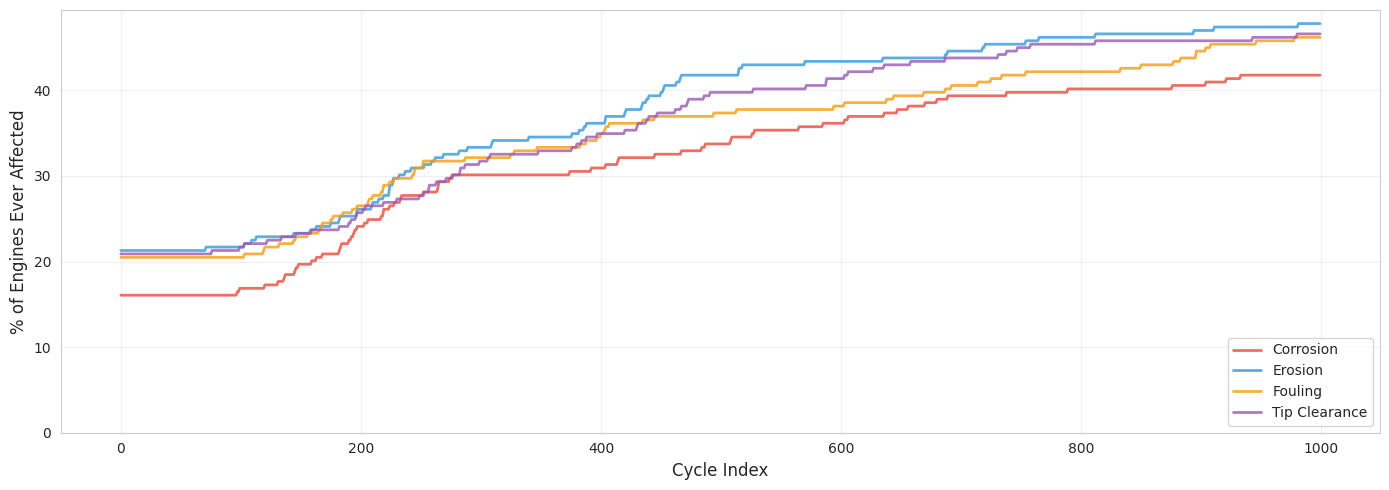

Figure 1b: Cumulative fault experience across the fleet. The plot displays the percentage
of engines that have experienced each fault type by a given cycle, showing fault penetration rates.


In [40]:
# Plot 1b: Cumulative fault experience
fig, ax = plt.subplots(figsize=(14, 5))

# Calculate cumulative % of engines that have experienced each fault
fault_cumulative = pd.DataFrame(index=range(1000), columns=FAULT_COLS, data=0.0)

for engine in df_fleet['engine_key'].unique():
    engine_data = df_fleet[df_fleet['engine_key'] == engine].sort_values('cycle')
    
    for fault in FAULT_COLS:
        if engine_data[fault].sum() > 0:
            first_fault_cycle = engine_data[engine_data[fault] == 1]['cycle'].iloc[0]
            fault_cumulative.loc[first_fault_cycle:, fault] += 1

# Convert to percentages
for fault in FAULT_COLS:
    fault_cumulative[fault] = (fault_cumulative[fault] / total_engines) * 100

# Plot cumulative percentage
for fault in FAULT_COLS:
    ax.plot(fault_cumulative.index, fault_cumulative[fault], 
            label=fault.replace('_', ' ').title(), 
            color=FAULT_COLORS[fault], 
            linewidth=2, alpha=0.8)

ax.set_xlabel('Cycle Index', fontsize=12)
ax.set_ylabel('% of Engines Ever Affected', fontsize=12)
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'plot1b_cumulative_fault_experience.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Figure 1b: Cumulative fault experience across the fleet. The plot displays the percentage")
print("of engines that have experienced each fault type by a given cycle, showing fault penetration rates.")

### 2.2.2 Fault Duration and Persistence

**Plot 2 – Fault duration distribution**

This plot quantifies how long faults persist once they occur and establishes an upper bound on meaningful temporal aggregation.

In [41]:
# Function to compute contiguous fault segments
def compute_fault_durations(df, engine_key_col='engine_key', cycle_col='cycle'):
    """
    Compute durations of contiguous fault segments for each fault type.
    
    Returns: dictionary of {fault_name: list of durations}
    """
    fault_durations = {fault: [] for fault in FAULT_COLS}
    
    # Process each engine separately
    for engine in df[engine_key_col].unique():
        engine_data = df[df[engine_key_col] == engine].sort_values(cycle_col)
        
        for fault in FAULT_COLS:
            fault_signal = engine_data[fault].values
            
            # Find contiguous segments where fault is active (value = 1)
            in_fault = False
            duration = 0
            
            for value in fault_signal:
                if value == 1:
                    duration += 1
                    in_fault = True
                else:
                    if in_fault and duration > 0:
                        fault_durations[fault].append(duration)
                    duration = 0
                    in_fault = False
            
            # Handle case where fault extends to end of series
            if in_fault and duration > 0:
                fault_durations[fault].append(duration)
    
    return fault_durations

# Compute fault durations
fault_durations = compute_fault_durations(df_fleet)

# Print statistics
print("\nFault duration statistics:")
for fault in FAULT_COLS:
    durations = fault_durations[fault]
    if len(durations) > 0:
        print(f"\n{fault}:")
        print(f"  Number of segments: {len(durations)}")
        print(f"  Mean duration: {np.mean(durations):.1f} cycles")
        print(f"  Median duration: {np.median(durations):.1f} cycles")
        print(f"  Min/Max duration: {np.min(durations)}/{np.max(durations)} cycles")


Fault duration statistics:

corrosion:
  Number of segments: 166
  Mean duration: 267.0 cycles
  Median duration: 230.0 cycles
  Min/Max duration: 1/1000 cycles

erosion:
  Number of segments: 181
  Mean duration: 283.2 cycles
  Median duration: 230.0 cycles
  Min/Max duration: 14/933 cycles

fouling:
  Number of segments: 184
  Mean duration: 289.8 cycles
  Median duration: 227.5 cycles
  Min/Max duration: 13/1000 cycles

tip_clearance:
  Number of segments: 173
  Mean duration: 275.5 cycles
  Median duration: 228.0 cycles
  Min/Max duration: 18/935 cycles


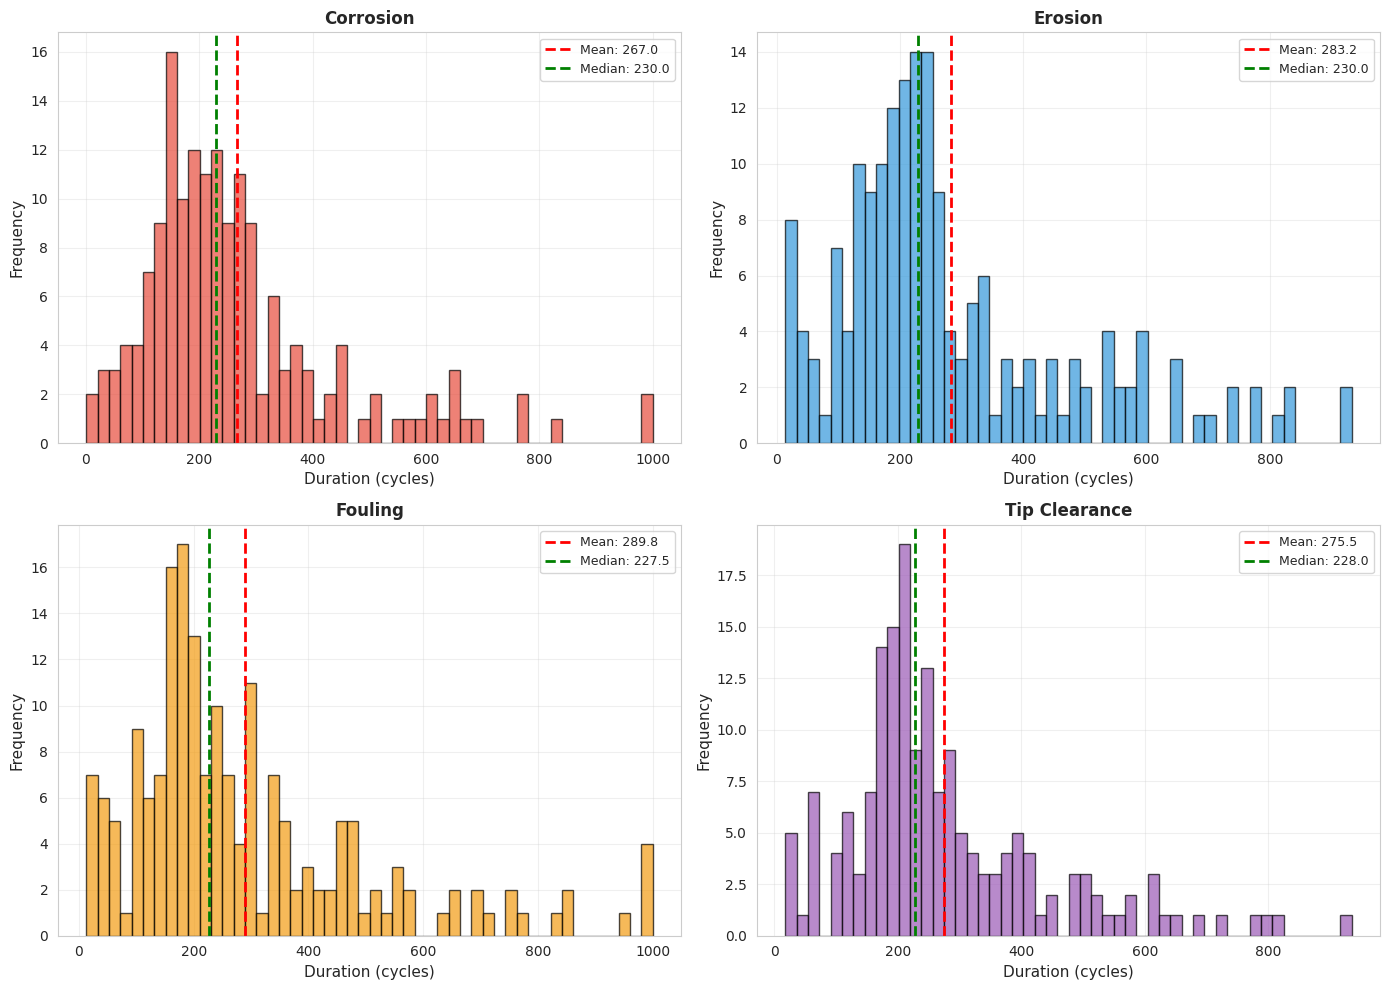

Figure 2: Distribution of fault duration for each fault type. Histograms show how long
contiguous fault episodes persist once they begin, with mean and median values indicated.


In [42]:
# Plot 2: Fault duration distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, fault in enumerate(FAULT_COLS):
    durations = fault_durations[fault]
    
    if len(durations) > 0:
        axes[idx].hist(durations, bins=50, color=FAULT_COLORS[fault], 
                      alpha=0.7, edgecolor='black')
        axes[idx].axvline(np.mean(durations), color='red', linestyle='--', 
                         linewidth=2, label=f'Mean: {np.mean(durations):.1f}')
        axes[idx].axvline(np.median(durations), color='green', linestyle='--', 
                         linewidth=2, label=f'Median: {np.median(durations):.1f}')
        
        axes[idx].set_xlabel('Duration (cycles)', fontsize=11)
        axes[idx].set_ylabel('Frequency', fontsize=11)
        axes[idx].set_title(f'{fault.replace("_", " ").title()}', fontsize=12, fontweight='bold')
        axes[idx].legend(fontsize=9)
        axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'plot2_fault_duration_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Figure 2: Distribution of fault duration for each fault type. Histograms show how long")
print("contiguous fault episodes persist once they begin, with mean and median values indicated.")

## 2.3 Individual Engine Sensor Timeline Analysis

This section visualizes all 20 sensors for a selected engine over its complete lifecycle, with fault periods highlighted.

### 2.3.1 All Sensors for Selected Engine

Visualize all sensor trajectories with fault period overlays to understand multi-sensor patterns for an individual engine.

Visualizing engine: 1_9
TAKEOFF sensors: 10, CRUISE sensors: 10


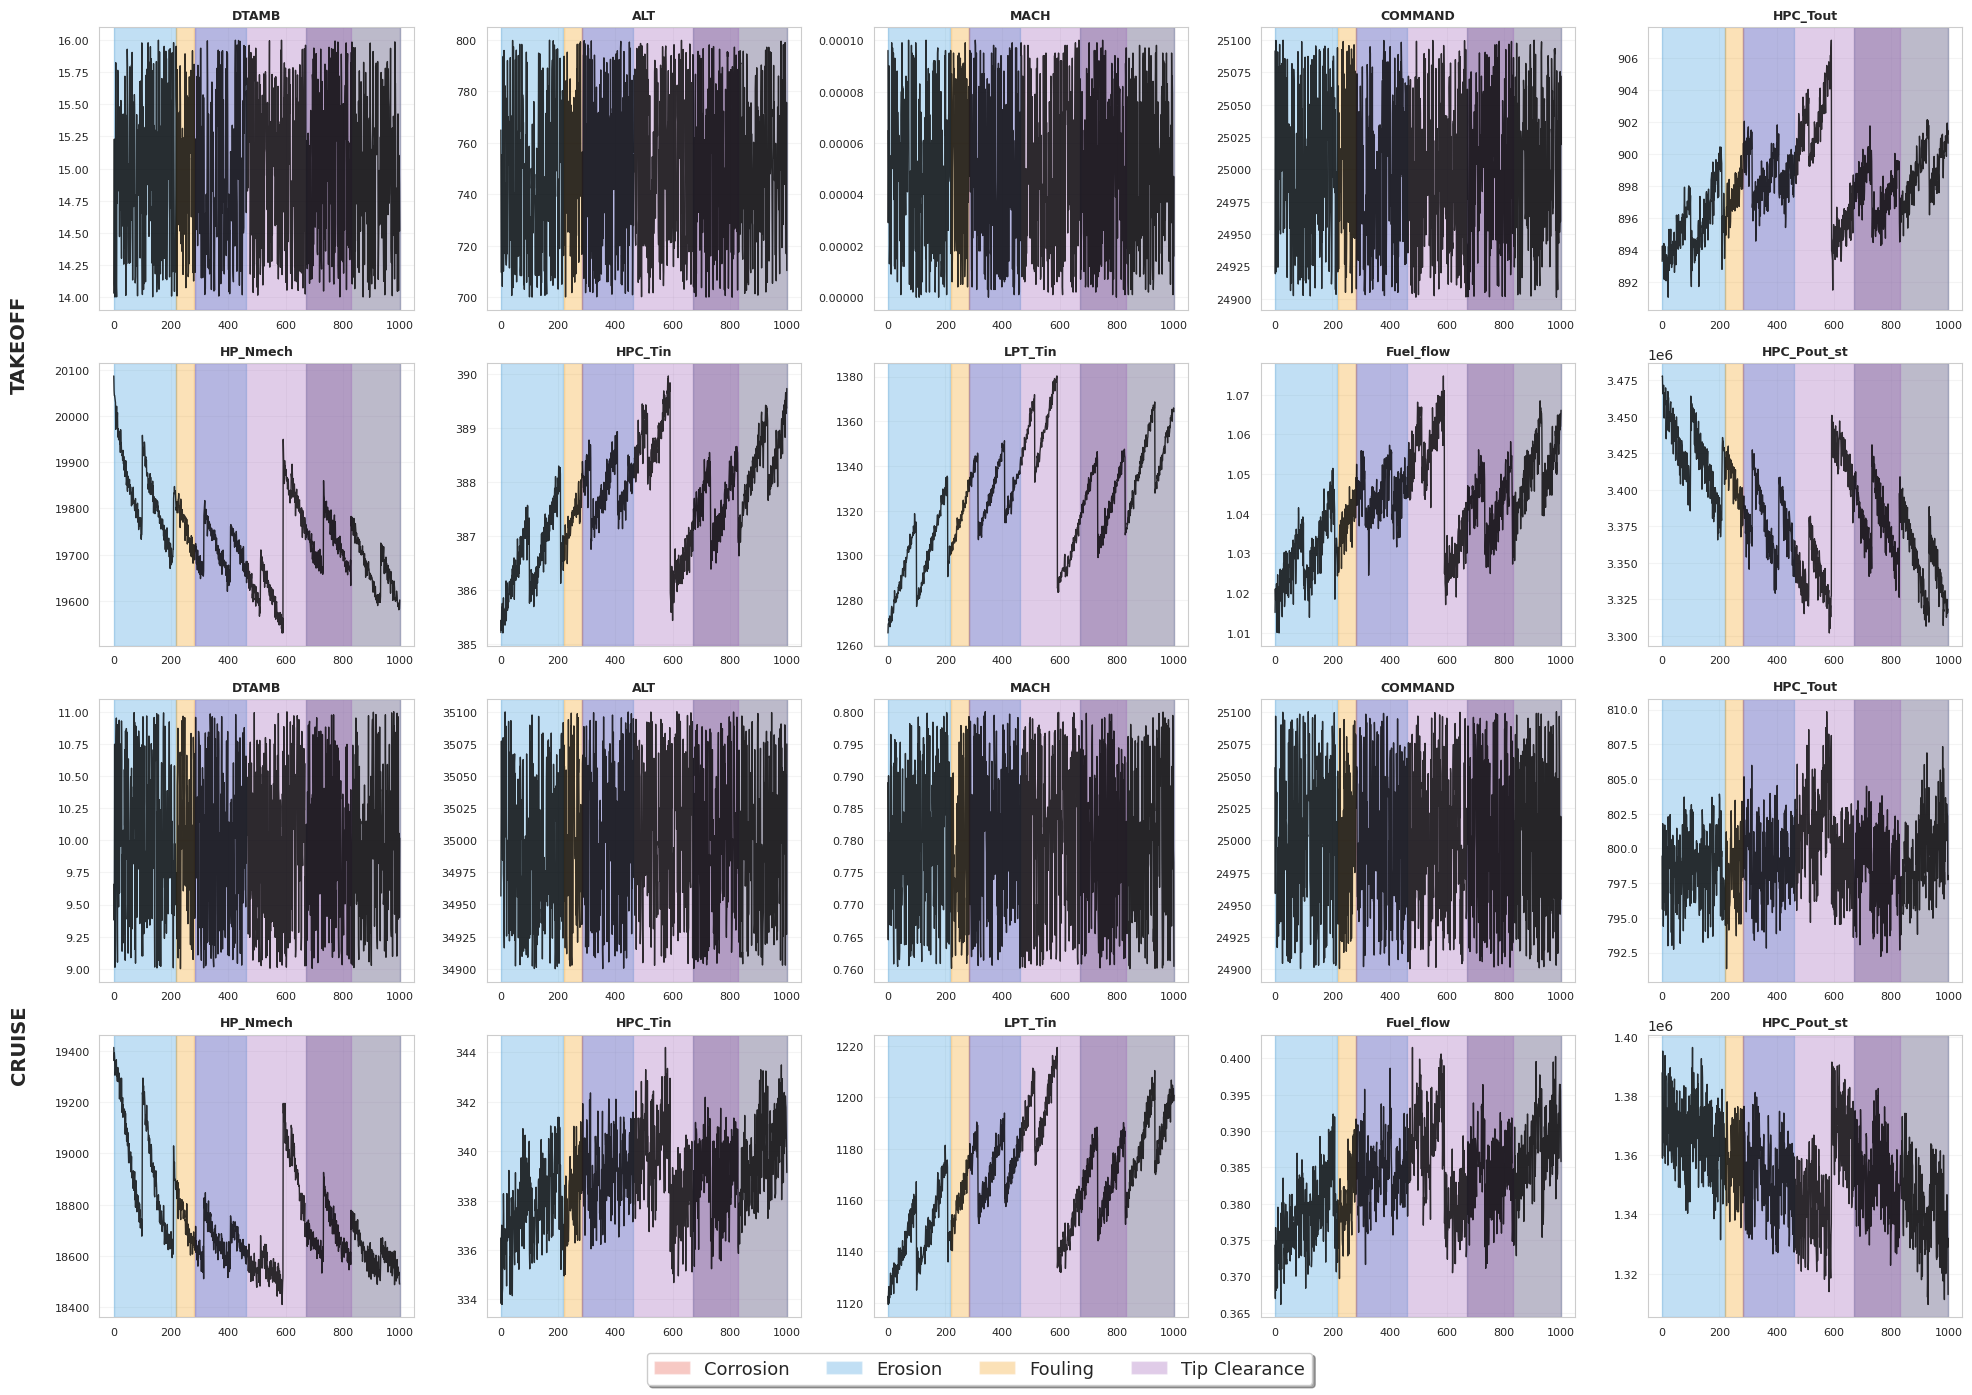

Figure: All 20 sensor measurements for engine 1_9 over its complete lifecycle.
Top 2 rows: TAKEOFF phase sensors. Bottom 2 rows: CRUISE phase sensors.
Colored backgrounds indicate active fault periods (see legend for fault types).


In [66]:
# Select engine for visualization (user can modify this)
engine_id = "1_9"  # Format: "cie_id_system_id"

print(f"Visualizing engine: {engine_id}")

# Extract engine data
engine_data = df_fleet[df_fleet['engine_key'] == engine_id].sort_values('cycle')

if len(engine_data) == 0:
    print(f"Error: Engine {engine_id} not found!")
    print(f"Available engines: {sorted(df_fleet['engine_key'].unique())[:10]}...")
else:
    # Separate TAKEOFF and CRUISE sensors
    takeoff_sensors = [s for s in FEATURE_COLS if 'TAKEOFF' in s]
    cruise_sensors = [s for s in FEATURE_COLS if 'CRUISE' in s]
    
    print(f"TAKEOFF sensors: {len(takeoff_sensors)}, CRUISE sensors: {len(cruise_sensors)}")
    
    # Create 4x5 grid: first 2 rows for TAKEOFF, last 2 rows for CRUISE
    fig, axes = plt.subplots(4, 5, figsize=(20, 14))
    
    # Plot TAKEOFF sensors (first 10 subplots)
    for idx, sensor in enumerate(takeoff_sensors):
        row = idx // 5
        col = idx % 5
        ax = axes[row, col]
        
        # Plot sensor values
        ax.plot(engine_data['cycle'], engine_data[sensor], 
               color='black', linewidth=1, alpha=0.8)
        
        # Add background shading for fault periods
        for fault in FAULT_COLS:
            fault_active = engine_data[engine_data[fault] == 1]['cycle'].values
            
            if len(fault_active) > 0:
                # Find contiguous segments
                segments = []
                start = fault_active[0]
                
                for i in range(1, len(fault_active)):
                    if fault_active[i] != fault_active[i-1] + 1:
                        segments.append((start, fault_active[i-1]))
                        start = fault_active[i]
                segments.append((start, fault_active[-1]))
                
                # Add shaded regions
                for seg_start, seg_end in segments:
                    ax.axvspan(seg_start, seg_end, alpha=0.3, color=FAULT_COLORS[fault])
        
        # Simplify sensor name for subplot title
        sensor_label = sensor.replace('TAKEOFF_', '').replace('DECKSMR', '')
        ax.set_title(sensor_label, fontsize=9, fontweight='bold')
        ax.grid(True, alpha=0.2)
        ax.tick_params(labelsize=8)
    
    # Plot CRUISE sensors (last 10 subplots)
    for idx, sensor in enumerate(cruise_sensors):
        row = 2 + (idx // 5)  # Rows 2 and 3
        col = idx % 5
        ax = axes[row, col]
        
        # Plot sensor values
        ax.plot(engine_data['cycle'], engine_data[sensor], 
               color='black', linewidth=1, alpha=0.8)
        
        # Add background shading for fault periods
        for fault in FAULT_COLS:
            fault_active = engine_data[engine_data[fault] == 1]['cycle'].values
            
            if len(fault_active) > 0:
                # Find contiguous segments
                segments = []
                start = fault_active[0]
                
                for i in range(1, len(fault_active)):
                    if fault_active[i] != fault_active[i-1] + 1:
                        segments.append((start, fault_active[i-1]))
                        start = fault_active[i]
                segments.append((start, fault_active[-1]))
                
                # Add shaded regions
                for seg_start, seg_end in segments:
                    ax.axvspan(seg_start, seg_end, alpha=0.3, color=FAULT_COLORS[fault])
        
        # Simplify sensor name for subplot title
        sensor_label = sensor.replace('CRUISE_', '').replace('DECKSMR', '')
        ax.set_title(sensor_label, fontsize=9, fontweight='bold')
        ax.grid(True, alpha=0.2)
        ax.tick_params(labelsize=8)
    
    # Add section labels for TAKEOFF and CRUISE
    fig.text(0.02, 0.75, 'TAKEOFF', fontsize=14, fontweight='bold', 
             rotation=90, va='center', ha='center')
    fig.text(0.02, 0.25, 'CRUISE', fontsize=14, fontweight='bold', 
             rotation=90, va='center', ha='center')
    
    # Add legend - centered below plots with larger font
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=FAULT_COLORS[fault], alpha=0.3, 
                            label=fault.replace('_', ' ').title()) 
                      for fault in FAULT_COLS]
    fig.legend(handles=legend_elements, loc='lower center', fontsize=13, ncol=4, 
               frameon=True, fancybox=True, shadow=True, bbox_to_anchor=(0.5, 0))
    
    plt.tight_layout(rect=[0.03, 0.03, 1, 1])  # Leave space for row labels and bottom legend
    plt.savefig(os.path.join(OUTPUT_DIR, f'plot_engine_{engine_id}_all_sensors.png'), 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Figure: All 20 sensor measurements for engine {engine_id} over its complete lifecycle.")
    print("Top 2 rows: TAKEOFF phase sensors. Bottom 2 rows: CRUISE phase sensors.")
    print("Colored backgrounds indicate active fault periods (see legend for fault types).")

### 2.4.1 Sensor Discriminative Strength

Rank sensors by their ability to distinguish between fault conditions using Mutual Information.

**About Mutual Information (MI):**

Mutual Information measures the amount of information obtained about one random variable by observing another random variable. In simpler terms, it quantifies how much knowing the value of one variable reduces uncertainty about another variable.

**Key Formula Concept:**
$$I(X;Y) = H(X) - H(X|Y)$$

Where:
- $I(X;Y)$ is the mutual information between variables X and Y
- $H(X)$ is the entropy (uncertainty) of X alone
- $H(X|Y)$ is the conditional entropy of X given Y

**What it measures:**
- **General statistical dependence**: Captures both linear AND non-linear relationships
- **Information sharing**: How much information the sensor values share with fault labels
- **Uncertainty reduction**: How much observing the sensor reduces uncertainty about fault state
- MI = 0 means variables are independent; higher values indicate stronger dependence

**Why it's better for time series:**
1. **No independence assumption**: Unlike ANOVA F-statistic, MI doesn't assume observations are independent
2. **Non-parametric**: No assumptions about normal distributions or equal variances
3. **Captures complexity**: Detects non-linear relationships that ANOVA would miss
4. **Temporal robustness**: Works well with autocorrelated time series data

**Interpretation:**
- Higher MI = stronger association between sensor and fault conditions
- MI values are in units of "bits" (information theory)
- Relative ranking matters more than absolute values

## 2.4 Sensor Relevance Across Fault Conditions

This subsection evaluates how strongly each sensor is associated with the fault labels, analyzing multiple statistical measures.

In [71]:
# Create a combined fault label for multi-class analysis
# Each unique combination of faults is a separate class
df_fleet['fault_label'] = (
    df_fleet['corrosion'].astype(int) * 8 + 
    df_fleet['erosion'].astype(int) * 4 + 
    df_fleet['fouling'].astype(int) * 2 + 
    df_fleet['tip_clearance'].astype(int)
)

print(f"Number of unique fault combinations: {df_fleet['fault_label'].nunique()}")

# Compute Mutual Information for each sensor
print("Computing Mutual Information scores...")

from sklearn.feature_selection import mutual_info_classif

# Prepare data for MI computation
X = df_fleet[FEATURE_COLS].values
y = df_fleet['fault_label'].values

# Compute mutual information
# Using 5 nearest neighbors for density estimation
mi_scores = mutual_info_classif(X, y, discrete_features=False, n_neighbors=5, random_state=42)

# Create DataFrame for visualization
sensor_effects = pd.DataFrame({
    'Sensor': FEATURE_COLS,
    'Mutual_Information': mi_scores
}).sort_values('Mutual_Information', ascending=False)

sensor_effects['Sensor_ID'] = range(len(sensor_effects))

print("\nTop most discriminative sensors:")
print(sensor_effects.head(20))
print(f"\nMI range: [{mi_scores.min():.4f}, {mi_scores.max():.4f}] bits")

Number of unique fault combinations: 16
Computing Mutual Information scores...

Top most discriminative sensors:
                        Sensor  Mutual_Information  Sensor_ID
5                  TAKEOFF_ALT            0.053587          0
19  TAKEOFF_DECKSMRHPC_Pout_st            0.043369          1
14     TAKEOFF_DECKSMRHPC_Tout            0.015066          2
16      TAKEOFF_DECKSMRHPC_Tin            0.012503          3
18    TAKEOFF_DECKSMRFuel_flow            0.011770          4
13   CRUISE_DECKSMRHPC_Pout_st            0.009063          5
8       CRUISE_DECKSMRHPC_Tout            0.007041          6
17      TAKEOFF_DECKSMRLPT_Tin            0.006938          7
11       CRUISE_DECKSMRLPT_Tin            0.006082          8
15     TAKEOFF_DECKSMRHP_Nmech            0.004254          9
10       CRUISE_DECKSMRHPC_Tin            0.003796         10
9       CRUISE_DECKSMRHP_Nmech            0.002646         11
2                  CRUISE_MACH            0.001576         12
1                  

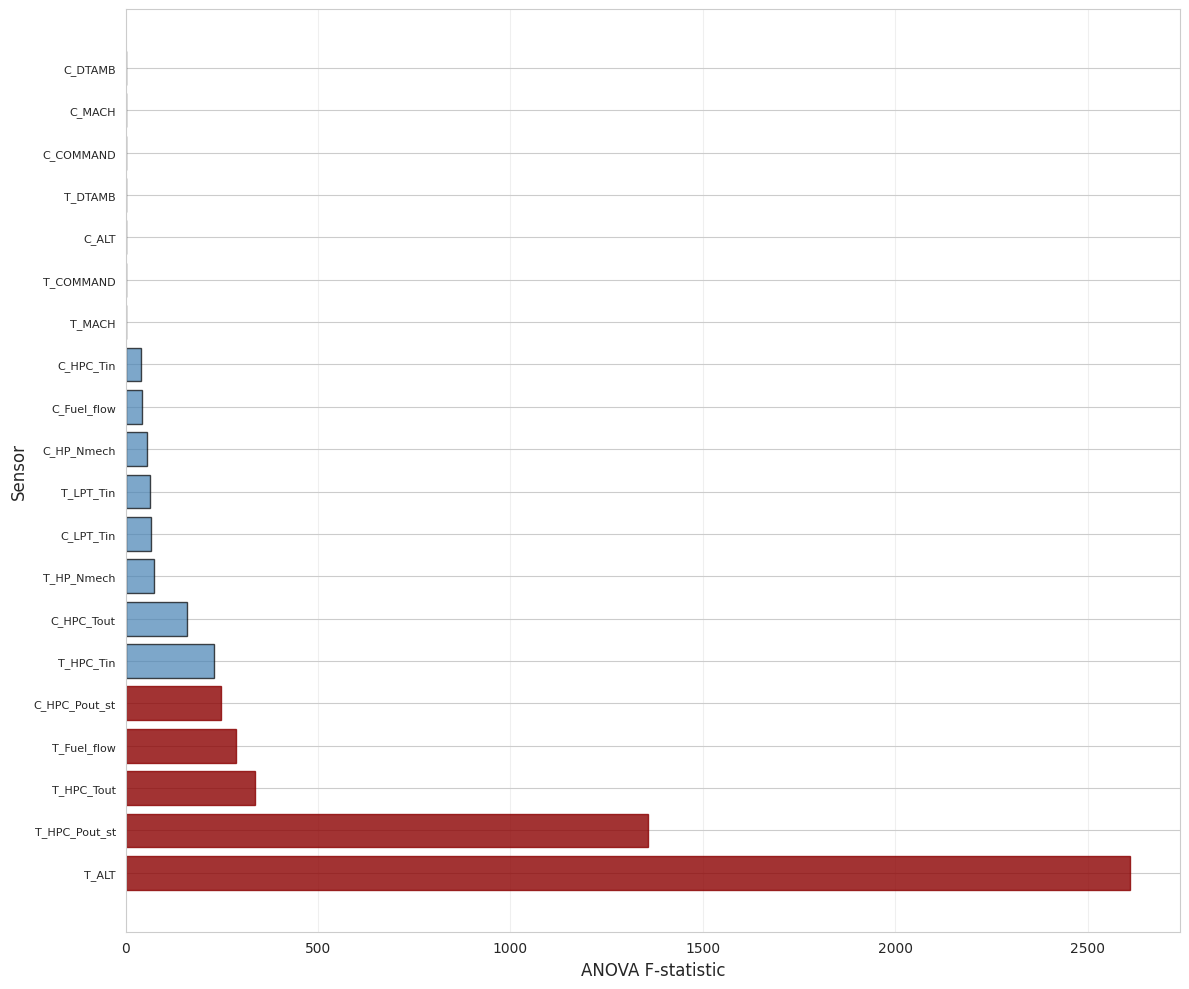

Figure 3: Sensor effect size ranking for all sensors. Higher F-statistics indicate
stronger discriminative power for distinguishing between fault conditions.


In [ ]:
# Plot 3: Sensor effect size ranking - ALL SENSORS
fig, ax = plt.subplots(figsize=(12, 10))

# Create bar plot
bars = ax.barh(range(len(sensor_effects)), sensor_effects['Mutual_Information'], 
               color='steelblue', alpha=0.7, edgecolor='black')

# Color top 5 sensors differently
for i in range(min(5, len(bars))):
    bars[i].set_color('darkred')
    bars[i].set_alpha(0.8)

# Simplify sensor names for readability
all_sensor_labels = [s.replace('CRUISE_', 'C_').replace('TAKEOFF_', 'T_').replace('DECKSMR', '') 
                     for s in sensor_effects['Sensor']]

ax.set_yticks(range(len(sensor_effects)))
ax.set_yticklabels(all_sensor_labels, fontsize=8)
ax.set_xlabel('Mutual Information (bits)', fontsize=12)
ax.set_ylabel('Sensor', fontsize=12)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'plot3_sensor_mutual_information_ranking.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Figure 3: Sensor discriminative power ranking using Mutual Information. Higher MI values")
print("indicate stronger statistical dependence between sensor and fault conditions, capturing")
print("both linear and non-linear relationships without assuming observation independence.")

### 2.4.2 Multi-Metric Sensor-Fault Analysis

Analyze sensor responses to faults using mean shifts, variability changes, and range differences.

In [72]:
# Compute multiple statistics for sensor-fault analysis
print("Computing sensor statistics for each fault condition...")

# Baseline: no faults active
baseline_data = df_fleet[(df_fleet[FAULT_COLS] == 0).all(axis=1)][FEATURE_COLS]
baseline_mean = baseline_data.mean()
baseline_std = baseline_data.std()

# Compute mean shifts and std changes for ALL sensors
mean_shifts = pd.DataFrame(index=FEATURE_COLS, columns=FAULT_COLS)
std_ratios = pd.DataFrame(index=FEATURE_COLS, columns=FAULT_COLS)

for fault in FAULT_COLS:
    fault_data = df_fleet[df_fleet[fault] == 1][FEATURE_COLS]
    
    # Mean shift (standardized)
    fault_mean = fault_data.mean()
    shift = (fault_mean - baseline_mean) / (baseline_std + 1e-6)
    mean_shifts[fault] = shift
    
    # Std ratio (variability change)
    fault_std = fault_data.std()
    std_ratio = fault_std / (baseline_std + 1e-6)
    std_ratios[fault] = std_ratio

mean_shifts = mean_shifts.astype(float)
std_ratios = std_ratios.astype(float)

print("Statistics computation complete")
print(f"Baseline samples: {len(baseline_data)}")
print(f"Mean shift range: [{mean_shifts.values.min():.2f}σ, {mean_shifts.values.max():.2f}σ]")
print(f"Std ratio range: [{std_ratios.values.min():.2f}, {std_ratios.values.max():.2f}]")

Computing sensor statistics for each fault condition...
Statistics computation complete
Baseline samples: 94534
Mean shift range: [-0.58σ, 0.88σ]
Std ratio range: [0.96, 1.77]


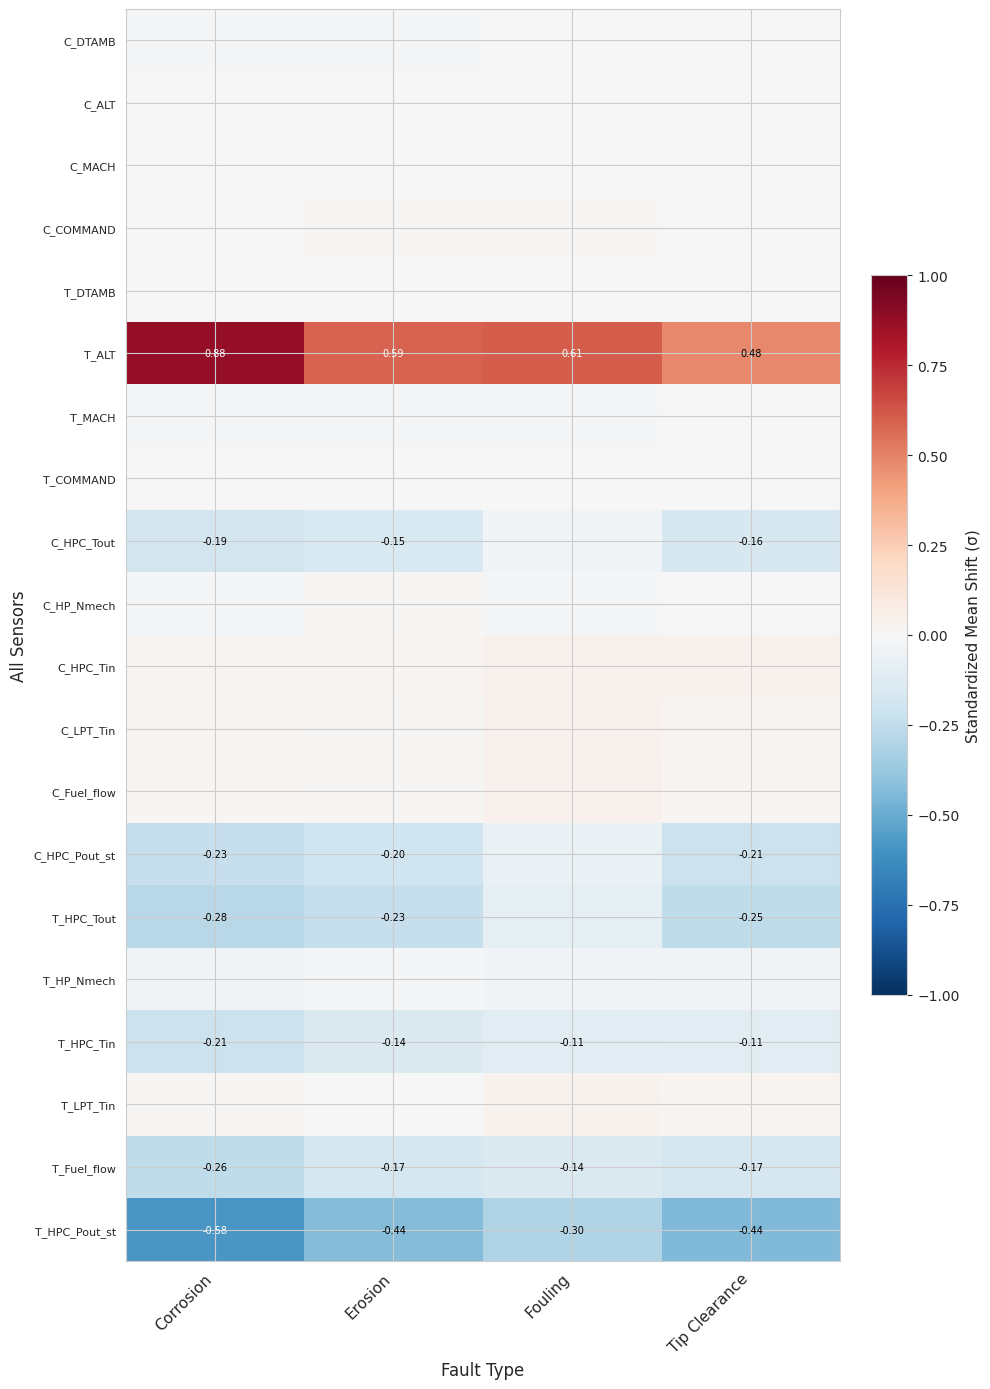

Figure 4a: Standardized mean shift of all sensors under each fault condition.
Values represent change in standard deviations from baseline (no-fault) condition.


In [73]:
# Plot 4a: Mean shift heatmap (ALL SENSORS)
fig, ax = plt.subplots(figsize=(10, 14))

all_sensor_labels = [s.replace('CRUISE_', 'C_').replace('TAKEOFF_', 'T_').replace('DECKSMR', '') 
                     for s in FEATURE_COLS]
fault_labels = [f.replace('_', ' ').title() for f in FAULT_COLS]

vmax = max(abs(mean_shifts.values.min()), abs(mean_shifts.values.max()))
vmax = max(vmax, 1.0)

im = ax.imshow(mean_shifts.values, cmap='RdBu_r', aspect='auto', vmin=-vmax, vmax=vmax)

ax.set_xticks(range(len(FAULT_COLS)))
ax.set_yticks(range(len(FEATURE_COLS)))
ax.set_xticklabels(fault_labels, fontsize=11, rotation=45, ha='right')
ax.set_yticklabels(all_sensor_labels, fontsize=8)

cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Standardized Mean Shift (σ)', fontsize=11)

for i in range(len(FEATURE_COLS)):
    for j in range(len(FAULT_COLS)):
        value = mean_shifts.values[i, j]
        if abs(value) > vmax * 0.1:
            text_color = 'white' if abs(value) > vmax * 0.5 else 'black'
            ax.text(j, i, f'{value:.2f}', ha='center', va='center', 
                   color=text_color, fontsize=7)

ax.set_xlabel('Fault Type', fontsize=12)
ax.set_ylabel('All Sensors', fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'plot4a_sensor_fault_mean_shift.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Figure 4a: Standardized mean shift of all sensors under each fault condition.")
print("Values represent change in standard deviations from baseline (no-fault) condition.")

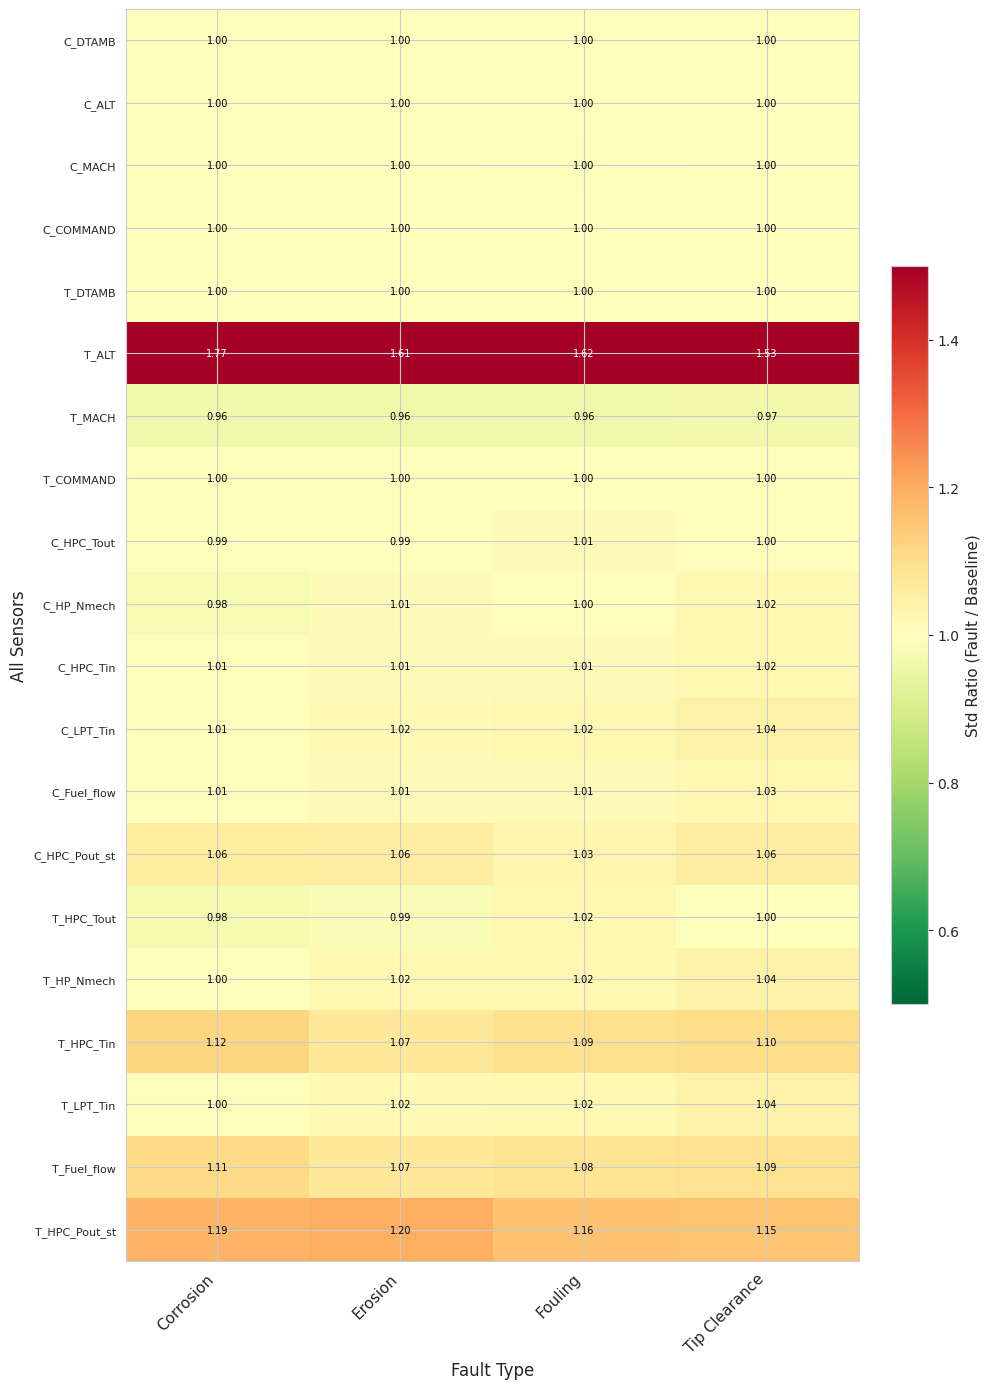

Figure 4b: Variability ratio of all sensors under fault conditions.
Values >1 indicate increased variability, <1 indicate reduced variability under fault.


In [74]:
# Plot 4b: Standard deviation ratio heatmap (ALL SENSORS)
fig, ax = plt.subplots(figsize=(10, 14))

all_sensor_labels = [s.replace('CRUISE_', 'C_').replace('TAKEOFF_', 'T_').replace('DECKSMR', '') 
                     for s in FEATURE_COLS]
fault_labels = [f.replace('_', ' ').title() for f in FAULT_COLS]

vmin, vmax = 0.5, 1.5  # Ratio scale

im = ax.imshow(std_ratios.values, cmap='RdYlGn_r', aspect='auto', vmin=vmin, vmax=vmax)

ax.set_xticks(range(len(FAULT_COLS)))
ax.set_yticks(range(len(FEATURE_COLS)))
ax.set_xticklabels(fault_labels, fontsize=11, rotation=45, ha='right')
ax.set_yticklabels(all_sensor_labels, fontsize=8)

cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Std Ratio (Fault / Baseline)', fontsize=11)

for i in range(len(FEATURE_COLS)):
    for j in range(len(FAULT_COLS)):
        value = std_ratios.values[i, j]
        if not np.isnan(value):
            text_color = 'white' if value > 1.2 or value < 0.8 else 'black'
            ax.text(j, i, f'{value:.2f}', ha='center', va='center', 
                   color=text_color, fontsize=7)

ax.set_xlabel('Fault Type', fontsize=12)
ax.set_ylabel('All Sensors', fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'plot4b_sensor_fault_variability_change.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Figure 4b: Variability ratio of all sensors under fault conditions.")
print("Values >1 indicate increased variability, <1 indicate reduced variability under fault.")

## 2.5 Event-Aligned Temporal Fault Signatures

This subsection analyzes how sensor time series evolve around fault onset events. "Fault onset" refers to the first cycle where a fault transitions from inactive (0) to active (1).

### 2.5.1 Event-Aligned Mean Trajectories

This plot characterizes the temporal response of sensors around fault onset events. By aligning all onset events to t=0 and averaging sensor trajectories across engines, we observe pre-fault behavior (t < 0), immediate response at onset (t = 0), and post-fault evolution (t > 0). This reveals whether faults produce abrupt or gradual sensor signatures.

In [50]:
# Function to find fault onset events
def find_fault_onsets(df, engine_key_col='engine_key', cycle_col='cycle'):
    """
    Find the cycle index where each fault first becomes active for each engine.
    
    Returns: dictionary of {fault: [(engine_key, onset_cycle), ...]}
    """
    fault_onsets = {fault: [] for fault in FAULT_COLS}
    
    for engine in df[engine_key_col].unique():
        engine_data = df[df[engine_key_col] == engine].sort_values(cycle_col)
        
        for fault in FAULT_COLS:
            fault_signal = engine_data[fault].values
            cycles = engine_data[cycle_col].values
            
            # Find first transition from 0 to 1
            for i in range(1, len(fault_signal)):
                if fault_signal[i] == 1 and fault_signal[i-1] == 0:
                    fault_onsets[fault].append((engine, cycles[i]))
                    break  # Only first onset per engine
    
    return fault_onsets

# Find fault onsets
print("Finding fault onset events...")
fault_onsets = find_fault_onsets(df_fleet)

for fault in FAULT_COLS:
    print(f"{fault}: {len(fault_onsets[fault])} onset events detected")

Finding fault onset events...
corrosion: 94 onset events detected
erosion: 104 onset events detected
fouling: 105 onset events detected
tip_clearance: 97 onset events detected


In [51]:
# Function to extract event-aligned sensor trajectories
def extract_aligned_trajectories(df, fault_onsets, sensor, fault, 
                                 window_before=50, window_after=100,
                                 engine_key_col='engine_key', cycle_col='cycle'):
    """
    Extract sensor trajectories aligned to fault onset.
    
    Returns: (relative_cycles, mean_trajectory, std_trajectory)
    """
    trajectories = []
    
    for engine, onset_cycle in fault_onsets[fault]:
        engine_data = df[df[engine_key_col] == engine].sort_values(cycle_col)
        
        # Extract window around onset
        start_cycle = max(0, onset_cycle - window_before)
        end_cycle = min(engine_data[cycle_col].max(), onset_cycle + window_after)
        
        window_data = engine_data[
            (engine_data[cycle_col] >= start_cycle) & 
            (engine_data[cycle_col] <= end_cycle)
        ]
        
        if len(window_data) > window_before + 10:  # Ensure sufficient data
            relative_cycles = window_data[cycle_col].values - onset_cycle
            sensor_values = window_data[sensor].values
            trajectories.append((relative_cycles, sensor_values))
    
    if len(trajectories) == 0:
        return None, None, None
    
    # Align all trajectories to common time grid
    time_grid = np.arange(-window_before, window_after + 1)
    aligned_values = np.full((len(trajectories), len(time_grid)), np.nan)
    
    for i, (rel_cycles, values) in enumerate(trajectories):
        for j, t in enumerate(time_grid):
            idx = np.where(rel_cycles == t)[0]
            if len(idx) > 0:
                aligned_values[i, j] = values[idx[0]]
    
    # Compute mean and std
    mean_traj = np.nanmean(aligned_values, axis=0)
    std_traj = np.nanstd(aligned_values, axis=0)
    
    return time_grid, mean_traj, std_traj

print("Function defined: extract_aligned_trajectories")

Function defined: extract_aligned_trajectories


In [52]:
# Select top 3 most discriminative sensors for each fault
top_sensors = sensor_effects.head(6)['Sensor'].values

print(f"Selected sensors for event-aligned analysis: {list(top_sensors)}")

Selected sensors for event-aligned analysis: ['TAKEOFF_ALT', 'TAKEOFF_DECKSMRHPC_Pout_st', 'TAKEOFF_DECKSMRHPC_Tout', 'TAKEOFF_DECKSMRFuel_flow', 'CRUISE_DECKSMRHPC_Pout_st', 'TAKEOFF_DECKSMRHPC_Tin']


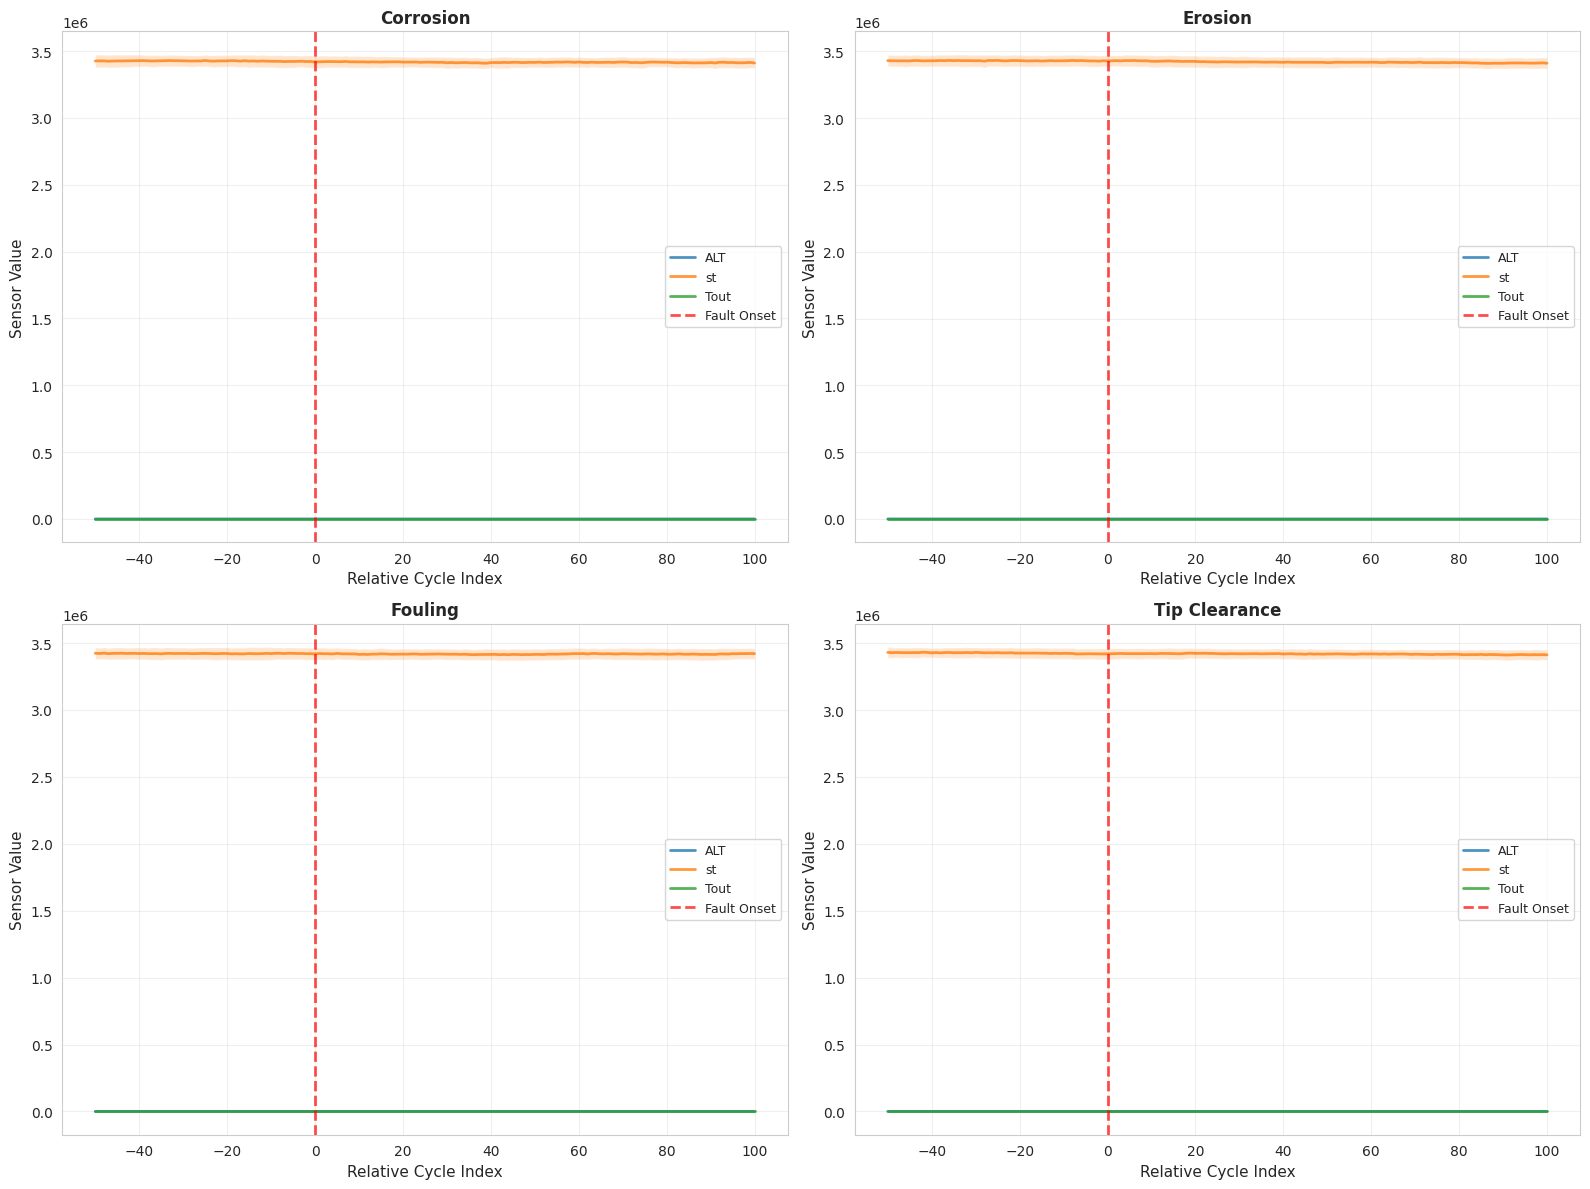

Figure 5: Event-aligned sensor trajectories around fault onset. Sensors are aligned to the
first cycle where each fault becomes active, showing averaged pre-fault and post-fault behavior.


In [53]:
# Plot 5: Event-aligned sensor trajectories
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for fault_idx, fault in enumerate(FAULT_COLS):
    ax = axes[fault_idx]
    
    # Plot top 3 sensors for this fault
    for sensor_idx, sensor in enumerate(top_sensors[:3]):
        time_grid, mean_traj, std_traj = extract_aligned_trajectories(
            df_fleet, fault_onsets, sensor, fault
        )
        
        if time_grid is not None:
            # Plot mean trajectory
            ax.plot(time_grid, mean_traj, label=sensor.split('_')[-1], 
                   linewidth=2, alpha=0.8)
            
            # Plot standard deviation band
            ax.fill_between(time_grid, 
                           mean_traj - std_traj, 
                           mean_traj + std_traj, 
                           alpha=0.2)
    
    # Add vertical line at onset
    ax.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Fault Onset')
    
    ax.set_xlabel('Relative Cycle Index', fontsize=11)
    ax.set_ylabel('Sensor Value', fontsize=11)
    ax.set_title(f'{fault.replace("_", " ").title()}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9, loc='best')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'plot5_event_aligned_sensor_trajectories.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Figure 5: Event-aligned sensor trajectories around fault onset. Sensors are aligned to the")
print("first cycle where each fault becomes active, showing averaged pre-fault and post-fault behavior.")

### 2.5.2 Multi-Sensor Response Patterns (Mean and Variability)

This plot identifies characteristic multi-sensor fault signatures, showing both mean response and variability changes around fault onset.

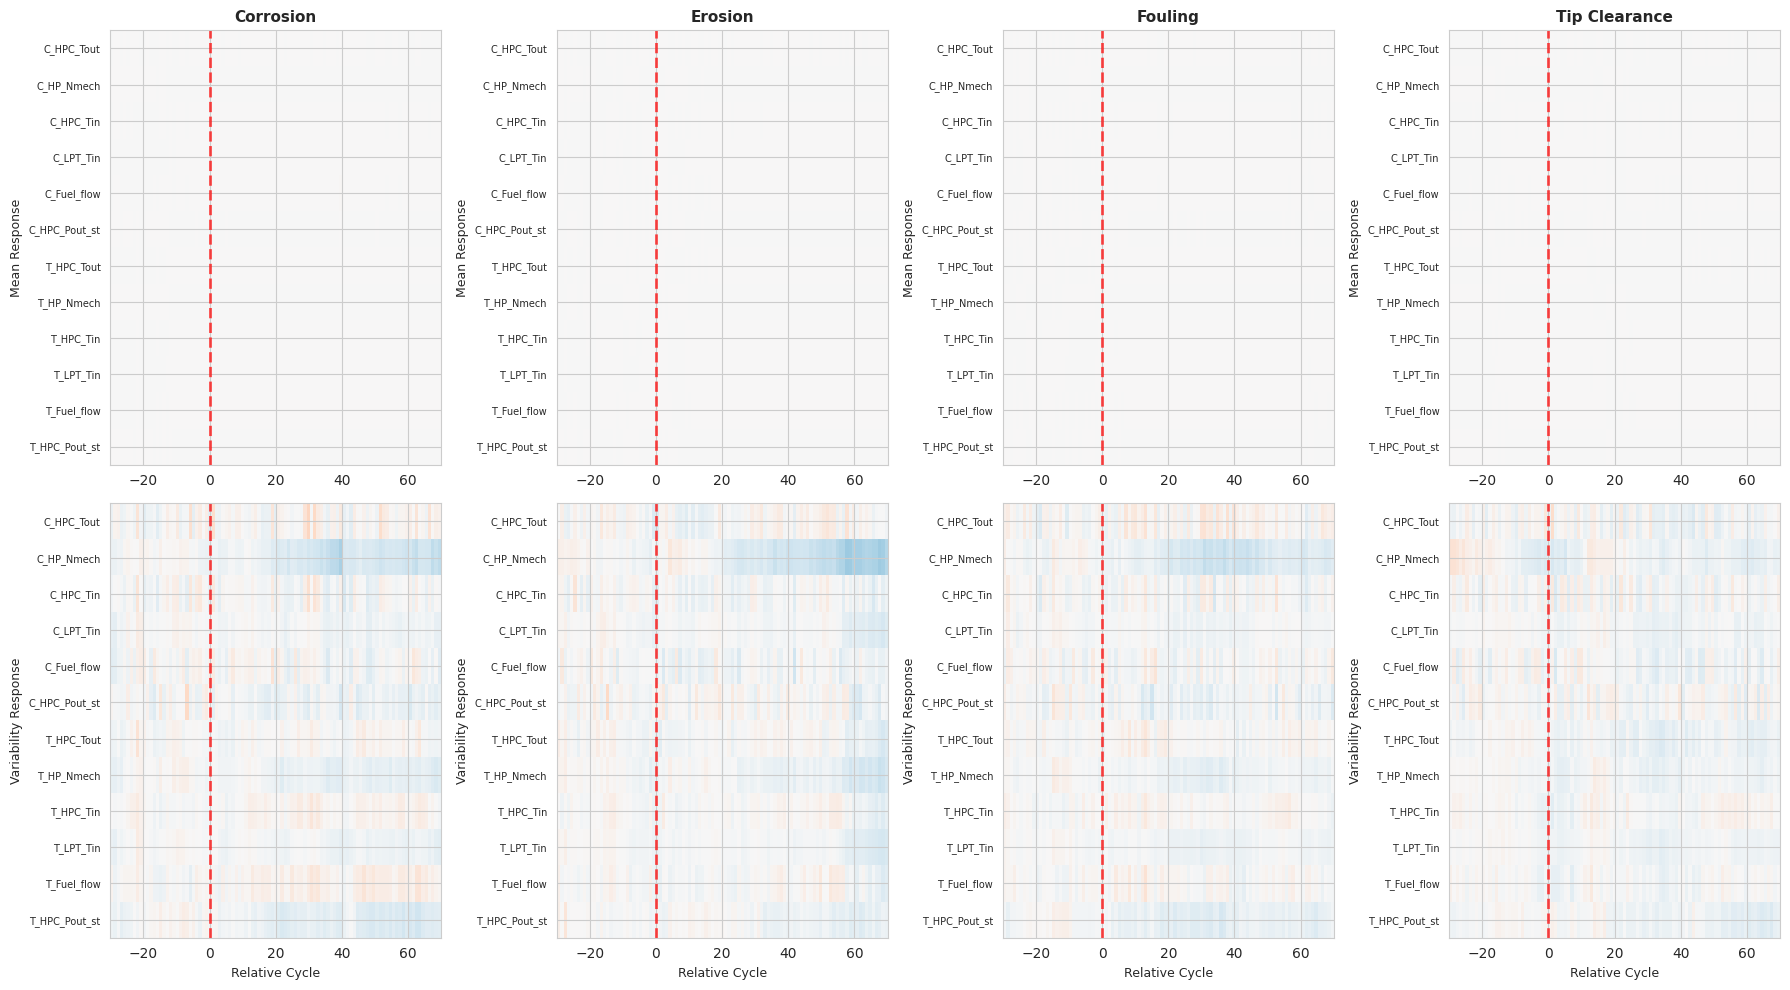

Figure 6: Multi-sensor response patterns around fault onset. Top row shows mean sensor
response, bottom row shows variability (standard deviation) response across the fleet.


In [ ]:
# Plot 6: Multi-sensor response patterns (mean AND variability)
fig, axes = plt.subplots(2, 4, figsize=(18, 10))

for fault_idx, fault in enumerate(FAULT_COLS):
    # Mean response (top row)
    ax_mean = axes[0, fault_idx]
    # Std response (bottom row)
    ax_std = axes[1, fault_idx]
    
    response_matrix_mean = []
    response_matrix_std = []
    valid_sensors = []
    
    for sensor in FEATURE_COLS:  # Use all sensors
        time_grid, mean_traj, std_traj = extract_aligned_trajectories(
            df_fleet, fault_onsets, sensor, fault, window_before=30, window_after=70
        )
        
        if time_grid is not None and not np.all(np.isnan(mean_traj)):
            # Normalize mean by pre-fault baseline
            baseline_mean = np.nanmean(mean_traj[time_grid < 0])
            normalized_mean = (mean_traj - baseline_mean) / (abs(baseline_mean) + 1e-6)
            response_matrix_mean.append(normalized_mean)
            
            # Normalize std
            baseline_std = np.nanmean(std_traj[time_grid < 0])
            normalized_std = (std_traj - baseline_std) / (abs(baseline_std) + 1e-6)
            response_matrix_std.append(normalized_std)
            
            valid_sensors.append(sensor)
    
    if len(response_matrix_mean) > 0:
        response_matrix_mean = np.array(response_matrix_mean)
        response_matrix_std = np.array(response_matrix_std)
        
        sensor_labels = [s.replace('CRUISE_', 'C_').replace('TAKEOFF_', 'T_').replace('DECKSMR', '') 
                        for s in valid_sensors]
        
        # Mean heatmap
        im1 = ax_mean.imshow(response_matrix_mean, cmap='RdBu_r', aspect='auto', 
                            vmin=-1, vmax=1, extent=[time_grid[0], time_grid[-1], 
                                                     len(valid_sensors), 0])
        ax_mean.set_yticks(np.arange(len(valid_sensors)) + 0.5)
        ax_mean.set_yticklabels(sensor_labels, fontsize=6)
        ax_mean.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.7)
        ax_mean.set_title(f'{fault.replace("_", " ").title()}', fontsize=11, fontweight='bold')
        ax_mean.set_ylabel('Mean Response', fontsize=9)
        
        # Std heatmap
        im2 = ax_std.imshow(response_matrix_std, cmap='RdBu_r', aspect='auto', 
                           vmin=-1, vmax=1, extent=[time_grid[0], time_grid[-1], 
                                                    len(valid_sensors), 0])
        ax_std.set_yticks(np.arange(len(valid_sensors)) + 0.5)
        ax_std.set_yticklabels(sensor_labels, fontsize=6)
        ax_std.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.7)
        ax_std.set_xlabel('Relative Cycle', fontsize=9)
        ax_std.set_ylabel('Variability Response', fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'plot6_sensor_response_heatmap_mean_std.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Figure 6: Multi-sensor response patterns around fault onset. Top row shows mean sensor")
print("response, bottom row shows variability (standard deviation) response across the fleet.")

## 2.6 Temporal Window Size Analysis

This section investigates how temporal aggregation window size affects fault detection capability.

### 2.6.1 Window Size Effect on Fault Discrimination

Analyze how different rolling window sizes affect the ability to discriminate between fault and no-fault conditions.

In [55]:
# Analyze effect of window size on sensor statistics and fault discrimination
print("Analyzing effect of window size on fault detection...")

window_sizes = [1, 5, 10, 20, 40, 80]
target_sensor = sensor_effects.head(1)['Sensor'].values[0]  # Most discriminative sensor

results_by_window = []

for window_size in window_sizes:
    print(f"Processing window size: {window_size}")
    # Apply rolling window
    df_windowed = df_fleet.copy()
    df_windowed[f'{target_sensor}_rolled'] = df_windowed.groupby('engine_key')[target_sensor].transform(
        lambda x: x.rolling(window=window_size, center=True, min_periods=1).mean()
    )
    
    # Compute F-statistic with windowed data
    groups = [df_windowed[df_windowed['fault_label'] == label][f'{target_sensor}_rolled'].values 
              for label in df_windowed['fault_label'].unique()]
    f_stat, p_val = stats.f_oneway(*groups)
    
    # Compute mean absolute difference
    baseline_mean = df_windowed[(df_windowed[FAULT_COLS] == 0).all(axis=1)][f'{target_sensor}_rolled'].mean()
    fault_diffs = []
    for fault in FAULT_COLS:
        fault_mean = df_windowed[df_windowed[fault] == 1][f'{target_sensor}_rolled'].mean()
        fault_diffs.append(abs(fault_mean - baseline_mean))
    
    results_by_window.append({
        'window_size': window_size,
        'f_statistic': f_stat,
        'mean_fault_separation': np.mean(fault_diffs)
    })

results_df = pd.DataFrame(results_by_window)
print("\nWindow size analysis complete")
print(results_df)

Analyzing effect of window size on fault detection...
Processing window size: 1
Processing window size: 5
Processing window size: 10
Processing window size: 20
Processing window size: 40
Processing window size: 80

Window size analysis complete
   window_size  f_statistic  mean_fault_separation
0            1  2609.307145             116.392446
1            5  2643.535980             116.381697
2           10  2648.054985             116.381767
3           20  2650.293903             116.376863
4           40  2651.622469             116.368991
5           80  2652.337265             116.362442


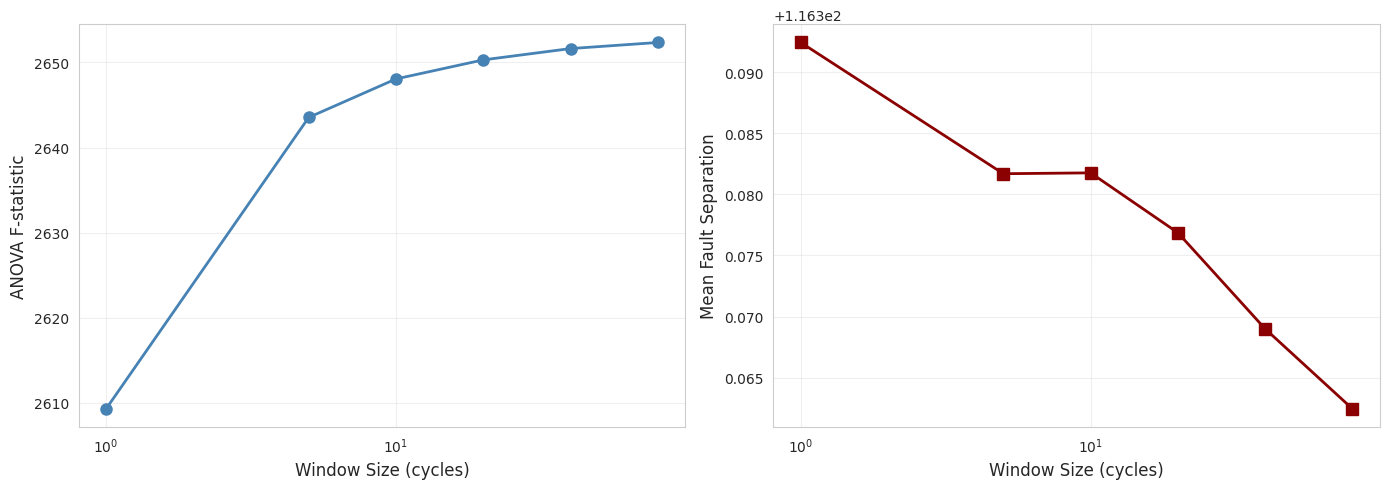

Figure: Effect of temporal window size on fault discrimination capability.
Left: F-statistic (higher = better discrimination). Right: Mean absolute separation between
fault and no-fault conditions. Helps determine optimal window size for temporal models.


In [56]:
# Plot: Window size effects on fault discrimination
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# F-statistic vs window size
axes[0].plot(results_df['window_size'], results_df['f_statistic'], 
            marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0].set_xlabel('Window Size (cycles)', fontsize=12)
axes[0].set_ylabel('ANOVA F-statistic', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].set_xscale('log')

# Mean fault separation vs window size
axes[1].plot(results_df['window_size'], results_df['mean_fault_separation'], 
            marker='s', linewidth=2, markersize=8, color='darkred')
axes[1].set_xlabel('Window Size (cycles)', fontsize=12)
axes[1].set_ylabel('Mean Fault Separation', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].set_xscale('log')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'plot_window_size_effects.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Figure: Effect of temporal window size on fault discrimination capability.")
print("Left: F-statistic (higher = better discrimination). Right: Mean absolute separation between")
print("fault and no-fault conditions. Helps determine optimal window size for temporal models.")

## Summary

This notebook has generated a comprehensive set of data visualizations covering:

1. **Temporal fault characteristics**: Prevalence timeline and cumulative experience
2. **Fault duration**: Persistence patterns for each fault type
3. **Individual engine analysis**: All sensors visualized for selected engine with fault overlays
4. **Sensor relevance**: Discriminative strength ranking for engine health sensors
5. **Multi-metric fault analysis**: Mean shifts and variability changes under fault conditions
6. **Event-aligned analysis**: Sensor trajectories and multi-sensor response patterns around fault onset
7. **Temporal window analysis**: Effect of aggregation window size on fault discrimination

All plots have been saved to the results directory with appropriate captions for inclusion in reports.